<a href="https://colab.research.google.com/github/Wayne-wyyking888/Stat-8931-GenAI/blob/main/chapter1/Chapter_I_Deep_Learning_Quick_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup and Packages load**

In [1]:
## package installation
! pip install accelerate datasets diffusers gym huggingface-hub ipykernel matplotlib numpy opencv-python pandas transformers
## Pytorch installation
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 # customized based on https://pytorch.org/get-started/locally/


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyar

## **In-Class Materials**
* Different types of deep learning & machine learning tools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
import time

### (1). (Supervised) ResNet18 for CIFAR-10 data Claasification

In [3]:
def print_epoch_stats(epoch, running_loss, train_loader, start_time, end_time):
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Time: {end_time - start_time}s')

def evaluate_model(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, y_pred

def visualize_predictions(images, predicted, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for ax, img, pred in zip(axes, images, predicted):
        img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for matplotlib
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[pred]}')
        ax.axis('off')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


100%|██████████| 170498071/170498071 [00:05<00:00, 33416166.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Using cuda
Epoch 1, Loss: 1.173001813995259, Time: 64.8062117099762s
Epoch 2, Loss: 0.7055026774135087, Time: 57.56619620323181s


Accuracy: 0.7412


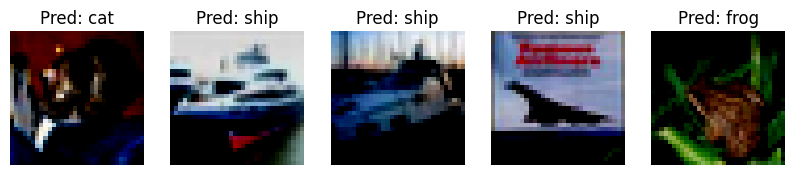

Epoch 3, Loss: 0.5251559876191342, Time: 53.589213848114014s
Epoch 4, Loss: 0.40210263087125997, Time: 58.569369316101074s


Accuracy: 0.8236


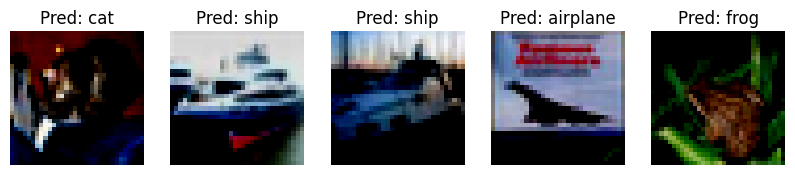

In [4]:
## training from the scratch
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Change the first conv layer
model.maxpool = nn.Identity()  # Omit max pooling
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for number of classes

# Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, download=True, transform=transform),
    batch_size=5, shuffle=False)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Check for GPU availability and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = model.to(device)

# Training settings
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(4):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    end_time = time.time()
    print_epoch_stats(epoch, running_loss, train_loader, start_time, end_time)

    # Visualization every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            accuracy, _ = evaluate_model(model, device, test_loader)
            print(f'Accuracy: {accuracy}')

            images, labels = next(iter(test_loader))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
            images = images.cpu()
            visualize_predictions(images, predicted, class_names)


* Visulization With t-SNE (dimension reduction to 2D)


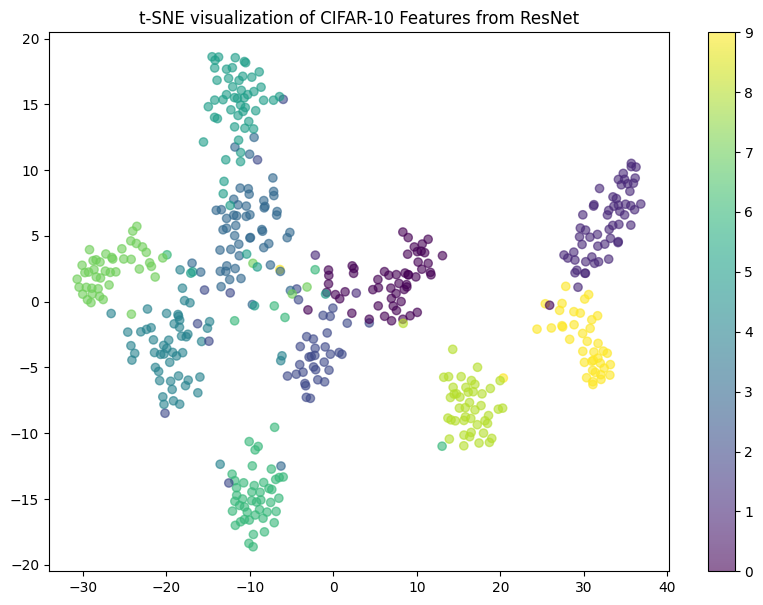

In [6]:
def extract_features_and_visualize(model, device, data_loader):
    # Modify the model to output features from the last layer before the fully connected layer
    model_modified = torch.nn.Sequential(*(list(model.children())[:-1]))
    model_modified = model_modified.to(device)

    # Extract features
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model_modified(images)
            output = output.view(output.size(0), -1)  # Flatten the outputs
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # t-SNE transformation
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features[:500])  # Using subset for manageability

    # Visualization
    plt.figure(figsize=(10, 7))
    plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels[:500], cmap='viridis', alpha=0.6)

    plt.colorbar()
    plt.title('t-SNE visualization of CIFAR-10 Features from ResNet')
    plt.show()

# evaluate the earlier trained model
extract_features_and_visualize(model, device, train_loader)

### (2). (Unsupervised) VAE, Image Generation

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # mu layer
        self.fc22 = nn.Linear(400, 20)  # log variance layer
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Training settings
batch_size = 1024
epochs = 10
learning_rate = 1e-3

# Data loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Initialize the model and send it to the device
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15954019.15it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482450.87it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4411714.19it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3606005.82it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Using cuda


* VAE loss and training recipes


Epoch 1, Loss: 258.117925, Time: 6.92 sec
Epoch 2, Loss: 184.438302, Time: 6.57 sec


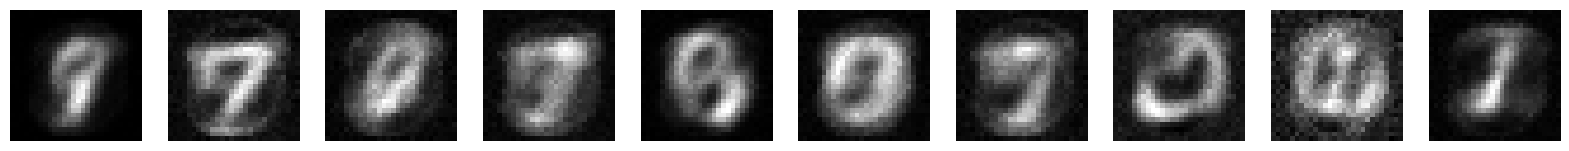

Epoch 3, Loss: 157.737707, Time: 5.82 sec
Epoch 4, Loss: 144.846722, Time: 6.80 sec


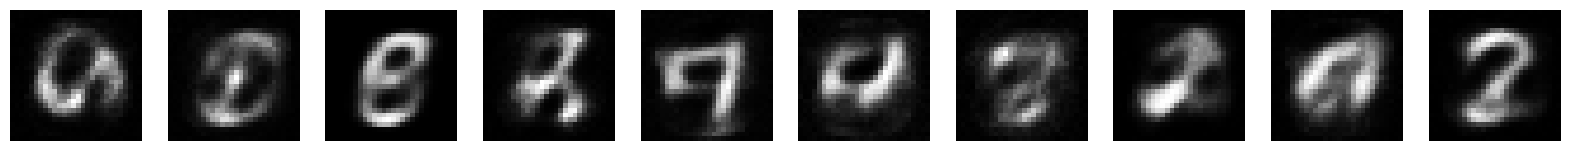

Epoch 5, Loss: 136.056192, Time: 5.88 sec
Epoch 6, Loss: 129.968399, Time: 6.61 sec


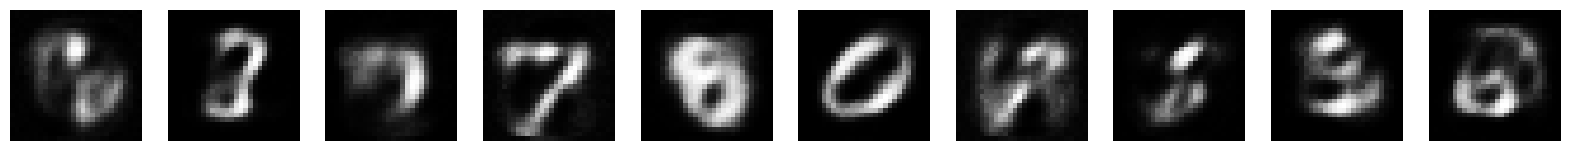

Epoch 7, Loss: 125.752593, Time: 7.55 sec
Epoch 8, Loss: 122.321753, Time: 6.03 sec


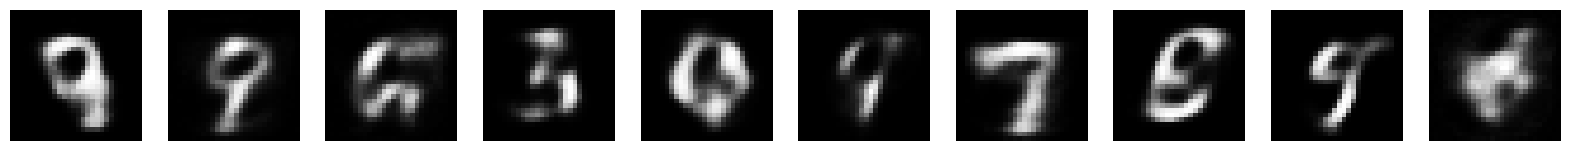

Epoch 9, Loss: 119.680126, Time: 6.61 sec
Epoch 10, Loss: 117.755092, Time: 5.86 sec


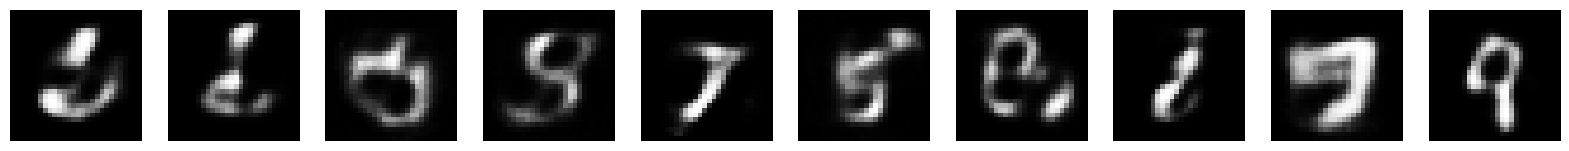

In [8]:
reconstruction_loss = nn.BCELoss(reduction='sum')
def loss_function(recon_x, x, mu, logvar):
    # Ensure x is reshaped correctly based on its actual batch size
    BCE = reconstruction_loss(recon_x, x.view(x.size(0), -1))  # x.size(0) is the actual batch size
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KL_divergence
def visualize_sampled_images(model, device, num_images=10):
    model.eval()
    with torch.no_grad():
        # Sample z from the prior distribution
        z = torch.randn(num_images, 20).to(device)
        sampled_images = model.decode(z)
        sampled_images = sampled_images.view(num_images, 1, 28, 28)
        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        for i, ax in enumerate(axes):
            # Move tensor to CPU and convert to numpy for visualization
            img = sampled_images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.show()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    start_time = time.time()

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Send data to the correct device
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end_time = time.time()
    epoch_duration = end_time - start_time

    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {average_loss:.6f}, Time: {epoch_duration:.2f} sec')

    # Visualize sampled images every two epochs
    if (epoch + 1) % 2 == 0:
        visualize_sampled_images(model, device, num_images=10)

### (3) (Semisupervised Learning): Mixture of labeled/unlabeled data. Use the labeled data to train a model and then give unlabeled data **pseudo-label**. Then *the pair of strong-augmented (hard distorted) input and its original pseudo-label is subsequently treated as labeled data in the training process*

* **Expanding the Decision Boundary**: By applying augmentations, the model is forced to learn more generalized decision boundaries that are robust to noise and small perturbations.

* **Consistency Regularization**: The model should give consistent predictions for both the original and augmented versions of an unlabeled example.

* **Pseudo-Labeling**: The model generates “almost-correct” (set a threshold) labels for the unlabeled data based on its own predictions, which are then used as supervision.

In [10]:
import numpy as np
import random
import torch
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
import matplotlib.pyplot as plt

PARAMETER_MAX = 10

def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX

def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)

class RandAugment:
    def __init__(self, n=2, m=10):
        self.n = n
        self.m = m
        self.augment_pool = self.rand_augment_pool()

    def __call__(self, img):
        ops = random.sample(self.augment_pool, self.n)
        for op, max_v, bias in ops:
            if max_v is not None:
                v = np.random.randint(1, self.m)
                img = op(img, v=v, max_v=max_v, bias=bias)
            else:
                img = op(img)
        return img

    def rand_augment_pool(self):
        return [
            (PIL.ImageOps.autocontrast, None, None),
            (self.brightness, 1.8, 0.1),
            (self.color, 1.8, 0.1),
            (self.contrast, 1.8, 0.1),
            (self.cutout, 40, None),
            (PIL.ImageOps.equalize, None, None),
            (PIL.ImageOps.invert, None, None),
            (self.posterize, 4, 0),
            (self.rotate, 30, None),
            (self.sharpness, 1.8, 0.1),
            (self.shear_x, 0.3, None),
            (self.shear_y, 0.3, None),
            (self.solarize, 256, None),
            (self.translate_x, 100, None),
            (self.translate_y, 100, None),
        ]

    def brightness(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Brightness(img).enhance(_float_parameter(v, max_v) + bias)

    def color(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Color(img).enhance(_float_parameter(v, max_v) + bias)

    def contrast(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Contrast(img).enhance(_float_parameter(v, max_v) + bias)

    def cutout(self, img, v, max_v, **kwargs):
        if v == 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(0, w)
        y0 = np.random.uniform(0, h)
        x1 = int(max(0, x0 - v / 2.))
        y1 = int(max(0, y0 - v / 2.))
        x2 = int(min(w, x0 + v))
        y2 = int(min(h, y0 + v))
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle((x1, y1, x2, y2), (127, 127, 127))
        return img

    def posterize(self, img, v, max_v, bias):
        return PIL.ImageOps.posterize(img, _int_parameter(v, max_v) + bias)

    def rotate(self, img, v, max_v, **kwargs):
        return img.rotate(_float_parameter(v, max_v))

    def sharpness(self, img, v, max_v, bias):
        return PIL.ImageEnhance.Sharpness(img).enhance(_float_parameter(v, max_v) + bias)

    def shear_x(self, img, v, max_v, **kwargs):
        return img.transform(img.size, PIL.Image.AFFINE, (1, _float_parameter(v, max_v), 0, 0, 1, 0))

    def shear_y(self, img, v, max_v, **kwargs):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, _float_parameter(v, max_v), 1, 0))

    def solarize(self, img, v, max_v, **kwargs):
        return PIL.ImageOps.solarize(img, 256 - _int_parameter(v, max_v))

    def translate_x(self, img, v, max_v, **kwargs):
        dx = _float_parameter(v, max_v) * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, dx, 0, 1, 0))

    def translate_y(self, img, v, max_v, **kwargs):
        dy = _float_parameter(v, max_v) * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, dy))

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split

class AugTransform:
    def __init__(self):
        data_stats = ((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.ToTensor(),
            transforms.Normalize(*data_stats)
        ])
        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(*data_stats)
        ])
        self.identity = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(*data_stats)
        ])

    def apply_weak(self, data):
        return self.weak(data)

    def apply_strong(self, data):
        return self.strong(data)

    def apply_identity(self, data):
        return self.identity(data)

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform_weak=None, transform_strong=None, mode='train'):
        self.dataset = dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong
        self.mode = mode  # 'train' or 'test'

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.mode == 'train':
            image_weak = self.transform_weak(image) if self.transform_weak else image
            image_strong = self.transform_strong(image) if self.transform_strong else image
            return image_weak, image_strong, label
        elif self.mode == 'test':
            image = self.transform_weak(image) if self.transform_weak else image
            return image, label

# Define augmentation transformer
augmenter = AugTransform()

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10('./data', train=True, download=True)
test_dataset = datasets.CIFAR10('./data', train=False, download=True)

# Split dataset into labeled and unlabeled subsets
num_labeled = 1000
labeled_indices, unlabeled_indices = train_test_split(range(len(full_dataset)), train_size=num_labeled, random_state=42)
labeled_dataset = Subset(full_dataset, labeled_indices)
unlabeled_dataset = Subset(full_dataset, unlabeled_indices)

# Creating datasets with transformations applied
transformed_labeled_dataset = TransformedDataset(labeled_dataset, transform_weak=augmenter.apply_weak, transform_strong=augmenter.apply_strong, mode='train')
transformed_unlabeled_dataset = TransformedDataset(unlabeled_dataset, transform_weak=augmenter.apply_weak, transform_strong=augmenter.apply_strong, mode='train')
transformed_test_dataset = TransformedDataset(test_dataset, transform_weak=augmenter.apply_identity, mode='test')

# Data loaders
batch_size = 50
labeled_loader = DataLoader(transformed_labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(transformed_unlabeled_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = models.resnet18(pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 2.278320074081421, Avg Batch Size: 50.95


Epoch 1, Validation accuracy: 0.2411


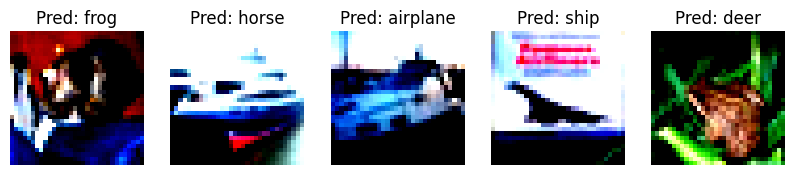

Epoch 2, Loss: 2.2755726516246795, Avg Batch Size: 50.45
Epoch 3, Loss: 2.0327452778816224, Avg Batch Size: 50.0
Epoch 4, Loss: 1.933590394258499, Avg Batch Size: 50.0
Epoch 5, Loss: 1.789529711008072, Avg Batch Size: 50.0
Epoch 6, Loss: 1.7276229381561279, Avg Batch Size: 50.0
Epoch 7, Loss: 1.717106145620346, Avg Batch Size: 50.25
Epoch 8, Loss: 1.6826475024223329, Avg Batch Size: 50.55
Epoch 9, Loss: 1.6218718469142914, Avg Batch Size: 50.9
Epoch 10, Loss: 1.5725003361701966, Avg Batch Size: 50.1
Epoch 11, Loss: 1.5652564346790314, Avg Batch Size: 50.25
Epoch 12, Loss: 1.5289869070053101, Avg Batch Size: 50.25
Epoch 13, Loss: 1.543579888343811, Avg Batch Size: 50.75
Epoch 14, Loss: 1.4561656355857848, Avg Batch Size: 50.4
Epoch 15, Loss: 1.5169780850410461, Avg Batch Size: 50.9
Epoch 16, Loss: 1.5012245416641234, Avg Batch Size: 50.75
Epoch 17, Loss: 1.3925425350666045, Avg Batch Size: 50.85
Epoch 18, Loss: 1.358503258228302, Avg Batch Size: 51.75
Epoch 19, Loss: 1.3606099307537078,

Epoch 21, Validation accuracy: 0.4188


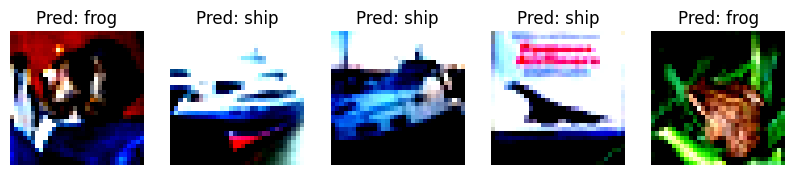

Epoch 22, Loss: 1.201074731349945, Avg Batch Size: 52.3
Epoch 23, Loss: 1.1949703454971314, Avg Batch Size: 52.15
Epoch 24, Loss: 1.1571453273296357, Avg Batch Size: 52.4
Epoch 25, Loss: 1.129670849442482, Avg Batch Size: 54.1
Epoch 26, Loss: 1.141979169845581, Avg Batch Size: 54.25
Epoch 27, Loss: 1.0707553893327713, Avg Batch Size: 54.75
Epoch 28, Loss: 1.0672002851963043, Avg Batch Size: 54.85
Epoch 29, Loss: 1.0588832437992095, Avg Batch Size: 55.8
Epoch 30, Loss: 0.9950131148099899, Avg Batch Size: 55.2
Epoch 31, Loss: 0.9968275845050811, Avg Batch Size: 56.4
Epoch 32, Loss: 1.0872870087623596, Avg Batch Size: 55.05
Epoch 33, Loss: 1.0107636272907257, Avg Batch Size: 55.45
Epoch 34, Loss: 0.9678375780582428, Avg Batch Size: 57.1
Epoch 35, Loss: 0.8706807434558869, Avg Batch Size: 57.35
Epoch 36, Loss: 0.8279665842652321, Avg Batch Size: 59.0
Epoch 37, Loss: 0.8460037559270859, Avg Batch Size: 59.05
Epoch 38, Loss: 0.8298182010650634, Avg Batch Size: 59.2
Epoch 39, Loss: 0.82637027

Epoch 41, Validation accuracy: 0.4543


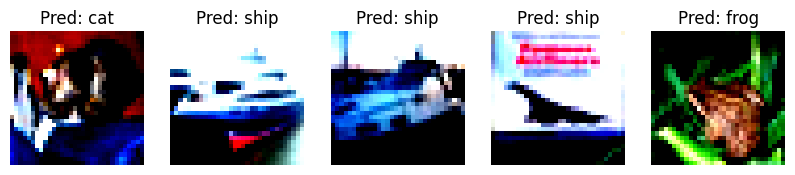

Epoch 42, Loss: 0.7818471372127533, Avg Batch Size: 62.95
Epoch 43, Loss: 0.7392576843500137, Avg Batch Size: 60.7
Epoch 44, Loss: 0.7511613428592682, Avg Batch Size: 60.85
Epoch 45, Loss: 0.7645093768835067, Avg Batch Size: 60.95
Epoch 46, Loss: 0.7573805809020996, Avg Batch Size: 60.4
Epoch 47, Loss: 0.699454054236412, Avg Batch Size: 62.85
Epoch 48, Loss: 0.7487172335386276, Avg Batch Size: 61.15
Epoch 49, Loss: 0.6406311005353927, Avg Batch Size: 62.75
Epoch 50, Loss: 0.6633696764707565, Avg Batch Size: 63.9
Epoch 51, Loss: 0.5985153466463089, Avg Batch Size: 65.2
Epoch 52, Loss: 0.6523152336478233, Avg Batch Size: 62.95
Epoch 53, Loss: 0.6391756504774093, Avg Batch Size: 62.85
Epoch 54, Loss: 0.5522927969694138, Avg Batch Size: 66.1
Epoch 55, Loss: 0.6436318412423134, Avg Batch Size: 64.75
Epoch 56, Loss: 0.5836406335234642, Avg Batch Size: 64.4
Epoch 57, Loss: 0.7076134890317917, Avg Batch Size: 64.25
Epoch 58, Loss: 0.5494196027517319, Avg Batch Size: 65.15
Epoch 59, Loss: 0.563

Epoch 61, Validation accuracy: 0.4416


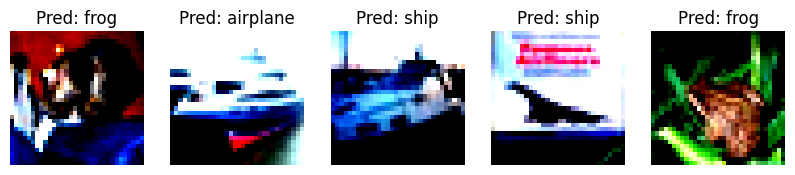

Epoch 62, Loss: 0.5829887434840202, Avg Batch Size: 65.95
Epoch 63, Loss: 0.5500745981931686, Avg Batch Size: 65.45
Epoch 64, Loss: 0.589838233590126, Avg Batch Size: 64.7
Epoch 65, Loss: 0.5274594217538834, Avg Batch Size: 65.45
Epoch 66, Loss: 0.5493963420391083, Avg Batch Size: 66.75
Epoch 67, Loss: 0.5615635260939598, Avg Batch Size: 67.3
Epoch 68, Loss: 0.5453014999628067, Avg Batch Size: 65.6
Epoch 69, Loss: 0.5451648935675621, Avg Batch Size: 66.5
Epoch 70, Loss: 0.4802844554185867, Avg Batch Size: 66.5
Epoch 71, Loss: 0.4824988588690758, Avg Batch Size: 68.55
Epoch 72, Loss: 0.5742398604750634, Avg Batch Size: 69.35
Epoch 73, Loss: 0.4894014298915863, Avg Batch Size: 66.1
Epoch 74, Loss: 0.4734220698475838, Avg Batch Size: 66.4
Epoch 75, Loss: 0.5724823564291001, Avg Batch Size: 67.35
Epoch 76, Loss: 0.5273261860013008, Avg Batch Size: 65.8
Epoch 77, Loss: 0.4565609470009804, Avg Batch Size: 68.15
Epoch 78, Loss: 0.5002790555357933, Avg Batch Size: 67.2
Epoch 79, Loss: 0.529938

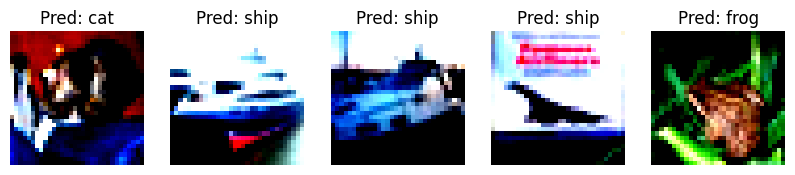

Epoch 82, Loss: 0.4835003688931465, Avg Batch Size: 67.3
Epoch 83, Loss: 0.4548767566680908, Avg Batch Size: 67.7
Epoch 84, Loss: 0.44660898447036745, Avg Batch Size: 68.45
Epoch 85, Loss: 0.48953803926706313, Avg Batch Size: 70.15
Epoch 86, Loss: 0.4557112634181976, Avg Batch Size: 69.4
Epoch 87, Loss: 0.4692519322037697, Avg Batch Size: 68.55
Epoch 88, Loss: 0.4515897884964943, Avg Batch Size: 67.55
Epoch 89, Loss: 0.4643222212791443, Avg Batch Size: 70.3
Epoch 90, Loss: 0.4581404447555542, Avg Batch Size: 69.65
Epoch 91, Loss: 0.4452883698046207, Avg Batch Size: 69.6
Epoch 92, Loss: 0.5210375562310219, Avg Batch Size: 68.15
Epoch 93, Loss: 0.43011791408061983, Avg Batch Size: 66.8
Epoch 94, Loss: 0.44821826219558714, Avg Batch Size: 70.05
Epoch 95, Loss: 0.42707347124814987, Avg Batch Size: 69.35
Epoch 96, Loss: 0.46184952557086945, Avg Batch Size: 71.1
Epoch 97, Loss: 0.42813841328024865, Avg Batch Size: 68.05
Epoch 98, Loss: 0.4489549122750759, Avg Batch Size: 70.9
Epoch 99, Loss:

Epoch 100, Validation accuracy: 0.4735


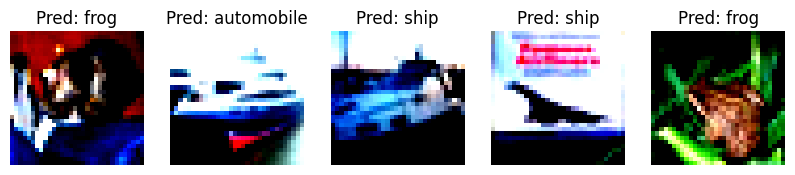

In [13]:
def train(model, labeled_loader, unlabeled_loader, test_loader, optimizer, device, epochs=100, threshold=0.9):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_batches = 0
        total_batch_size = 0  # To track average batch size per epoch

        # Create an iterator for unlabeled data
        unlabeled_iter = iter(unlabeled_loader)

        for labeled_data_weak, _, labels in labeled_loader:
            labeled_data_weak = labeled_data_weak.to(device)
            labels = labels.to(device)
            try:
                # Try to get a batch from unlabeled data
                unlabeled_data_weak, unlabeled_data_strong, _ = next(unlabeled_iter)
                unlabeled_data_weak = unlabeled_data_weak.to(device)
                unlabeled_data_strong = unlabeled_data_strong.to(device)
            except StopIteration:
                # Refresh iterator if the unlabeled loader is exhausted
                unlabeled_iter = iter(unlabeled_loader)
                unlabeled_data_weak, unlabeled_data_strong, _ = next(unlabeled_iter)
                unlabeled_data_weak = unlabeled_data_weak.to(device)
                unlabeled_data_strong = unlabeled_data_strong.to(device)

            # Generate pseudo-labels using weak augmentation
            with torch.no_grad():
                outputs = model(unlabeled_data_weak)
                soft_labels = torch.softmax(outputs, dim=1)
                max_probs, pseudo_labels = torch.max(soft_labels, dim=1)
                mask = max_probs > threshold

            # Generate high-confidence pseudo-labeled data
            if mask.sum() > 0:
                high_conf_data_strong = unlabeled_data_strong[mask]
                high_conf_labels = pseudo_labels[mask].to(device)
            else:
                high_conf_data_strong = torch.tensor([], device=device)
                high_conf_labels = torch.tensor([], dtype=torch.long, device=device)

            # Combine labeled and high-confidence pseudo-labeled data
            combined_data = torch.cat([labeled_data_weak, high_conf_data_strong], dim=0)
            combined_labels = torch.cat([labels, high_conf_labels], dim=0)

            # Forward pass
            outputs = model(combined_data)
            loss = criterion(outputs, combined_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1
            total_batch_size += combined_data.size(0)  # Track total batch size

        average_batch_size = total_batch_size / total_batches
        print(f'Epoch {epoch + 1}, Loss: {total_loss / total_batches}, Avg Batch Size: {average_batch_size}')

        # Visualization and accuracy every few epochs
        if epoch % 20 == 0 or epoch == epochs-1:
            accuracy, predicted = evaluate_model(model, device, test_loader)
            print(f'Epoch {epoch + 1}, Validation accuracy: {accuracy}')
            images, _ = next(iter(test_loader))
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            visualize_predictions(images.cpu(), predicted.cpu().numpy(), class_names)

train(model, labeled_loader, unlabeled_loader, test_loader, optimizer, device)